# Лабораторная работа №3
## Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей
## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Загрузка данных
В качестве набора данных использован набор данных по предсказанию уровня солнечной радиации - https://www.kaggle.com/dronio/SolarEnergy

In [2]:
from datetime import timedelta
data = pd.read_csv('SolarPrediction.csv', sep=",")
# Преобразование данных датасета в нужный формат
data['Data'] = pd.to_datetime(data['UNIXTime'], unit='s') + pd.DateOffset(hours=-10)
data['UNIXTime'] = data['Data'].dt.month
data.rename(columns={'UNIXTime': 'Month'}, inplace = True)
data['Data'] = data['Data'].dt.second + data['Data'].dt.minute*60 + data['Data'].dt.hour*60*60
data.rename(columns={'Data': 'Time(Seconds)'}, inplace = True)
data['TimeSunRise'] = pd.to_datetime(data['TimeSunRise'], format='%H:%M:%S').dt.time
data['TimeSunSet'] = pd.to_datetime(data['TimeSunSet'], format='%H:%M:%S').dt.time
data['TimeSunSet'] = (pd.to_timedelta(data['TimeSunSet'].astype(str)) - pd.to_timedelta(data['TimeSunRise'].astype(str))).dt.total_seconds()
data.rename(columns={'TimeSunSet': 'DayLenght(Seconds)'}, inplace = True)
data['TimeSunRise'] = pd.to_timedelta(data['TimeSunRise'].astype(str)).dt.total_seconds()
data.rename(columns={'TimeSunRise': 'TimeSunRise(Seconds)'}, inplace = True)
# Удаление ненужных столбцов
data.drop(['Time'], inplace=True, axis=1)
data = data.join(pd.get_dummies(data['Month'].astype(str)))
data.drop(['Month'], inplace=True, axis=1)
# Первые 5 строк датасета
data.head()

,Time(Seconds),Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise(Seconds),DayLenght(Seconds),10,11,12,9
0,86126,1.21,48,30.46,59,177.39,5.62,22380.0,43200.0,0,0,0,1
1,85823,1.21,48,30.46,58,176.78,3.37,22380.0,43200.0,0,0,0,1
2,85526,1.23,48,30.46,57,158.75,3.37,22380.0,43200.0,0,0,0,1
3,85221,1.21,48,30.46,60,137.71,3.37,22380.0,43200.0,0,0,0,1
4,84924,1.17,48,30.46,62,104.95,5.62,22380.0,43200.0,0,0,0,1


## Масштабирование данных

In [3]:
from sklearn.preprocessing import MinMaxScaler
# MinMax масштабирование
sc1 = MinMaxScaler()
for item in ['Time(Seconds)', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeSunRise(Seconds)', 'DayLenght(Seconds)']:
    data.loc[:, item] = sc1.fit_transform(data[[item]])
# Первые 5 строк получившегося датасета
data.head()

,Time(Seconds),Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise(Seconds),DayLenght(Seconds),10,11,12,9
0,0.999315,1.21,0.378378,0.72973,0.536842,0.492692,0.138765,0.12,0.673684,0,0,0,1
1,0.995800,1.21,0.378378,0.72973,0.526316,0.490996,0.083210,0.12,0.673684,0,0,0,1
2,0.992354,1.23,0.378378,0.72973,0.515789,0.440894,0.083210,0.12,0.673684,0,0,0,1
3,0.988815,1.21,0.378378,0.72973,0.547368,0.382426,0.083210,0.12,0.673684,0,0,0,1
4,0.985369,1.17,0.378378,0.72973,0.568421,0.291391,0.138765,0.12,0.673684,0,0,0,1


## Разделение выборки на обучающую и тестовую
С использованием метода train_test_split

In [4]:
from sklearn.model_selection import train_test_split
data_train, data_test, data_y_train, data_y_test = train_test_split(data[['Time(Seconds)', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeSunRise(Seconds)', 'DayLenght(Seconds)', '10', '11', '12', '9']], data['Radiation'], random_state=1)
# Обучающая выборка
data_train

,Time(Seconds),Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise(Seconds),DayLenght(Seconds),10,11,12,9
19310,0.115068,0.243243,0.567568,0.515789,0.443256,0.055556,0.54,0.126316,0,1,0,0
19368,0.915669,0.378378,0.675676,0.915789,0.307286,0.194321,0.52,0.147368,0,1,0,0
12448,0.428432,0.783784,0.783784,0.442105,0.164564,0.305432,0.20,0.494737,1,0,0,0
18105,0.302864,0.297297,0.621622,0.968421,0.458651,0.194321,0.58,0.105263,0,1,0,0
24541,0.932899,0.189189,0.432432,0.747368,0.573084,0.222222,1.00,0.010526,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
32511,0.605692,0.297297,0.540541,0.894737,0.269688,0.083210,0.68,0.052632,0,0,1,0
5192,0.679047,0.567568,0.459459,0.926316,0.187962,0.166667,0.04,0.894737,0,0,0,1
12172,0.407477,0.864865,0.864865,0.084211,0.158395,0.138765,0.20,0.484211,1,0,0,0
235,0.174290,0.324324,0.540541,0.389474,0.521230,0.166667,0.12,0.673684,0,0,0,1


In [5]:
# Тестовая выборка
data_test

,Time(Seconds),Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise(Seconds),DayLenght(Seconds),10,11,12,9
22830,0.891151,0.540541,0.810811,0.157895,0.622381,0.194321,0.38,0.252632,0,1,0,0
17281,0.174069,0.189189,0.648649,0.505263,0.304452,0.249877,0.62,0.084211,0,1,0,0
6136,0.682284,0.702703,0.567568,0.873684,0.856027,0.166667,0.02,0.957895,0,0,0,1
17582,0.121879,0.324324,0.729730,0.968421,0.386456,0.166667,0.60,0.094737,0,1,0,0
20747,0.121844,0.297297,0.675676,0.210526,0.468654,0.111111,0.48,0.168421,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15333,0.212568,0.405405,0.621622,0.905263,0.556494,0.083210,0.14,0.610526,1,0,0,0
13404,0.052516,0.486486,0.594595,0.978947,0.345968,0.194321,0.18,0.536842,1,0,0,0
7928,0.219484,0.351351,0.594595,0.989474,0.440977,0.138765,0.32,0.315789,1,0,0,0
7857,0.466630,0.459459,0.756757,0.957895,0.199994,0.333333,0.32,0.315789,1,0,0,0


## Первичное обучение модели

In [6]:
from sklearn.neighbors import KNeighborsRegressor

In [7]:
# Модель ближайших соседей с количеством ближайших соседей = 5
KNeighborsRegressorObj = KNeighborsRegressor(n_neighbors=5)
KNeighborsRegressorObj.fit(data_train, data_y_train)
target0_0 = KNeighborsRegressorObj.predict(data_train)
target0_1 = KNeighborsRegressorObj.predict(data_test)

## Оценка качества модели с помощью подходящих метрик

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score
# 1) Mean absolute error - средняя абсолютная ошибка
mean_absolute_error(data_y_test, target0_1)

41.82268086147822

In [9]:
# 2) Mean squared error - средняя квадратичная ошибка
mean_squared_error(data_y_test, target0_1)

9381.54396910426

In [10]:
# Root mean squared error - корень из средней квадратичной ошибки
# Значение RMSE сравнимо с MAE
mean_squared_error(data_y_test, target0_1, squared=False)

96.85837067132742

In [11]:
# 3) Median absolute error
median_absolute_error(data_y_test, target0_1)

1.1989999999999998

In [12]:
# 4) Метрика R2 или коэффициент детерминации
r2_score(data_y_test, target0_1)

0.9054334392402374

## Подбор гиперпараметра с использованием GridSearchCV и кросс-валидации

In [13]:
from sklearn.model_selection import cross_val_score, KFold, LeaveOneOut, ShuffleSplit
scores1_1 = cross_val_score(KNeighborsRegressor(n_neighbors=5), data[['Time(Seconds)', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeSunRise(Seconds)', 'DayLenght(Seconds)', '10', '11', '12', '9']], data['Radiation'], cv=5, scoring='r2')
scores1_1, np.mean(scores1_1)

(array([0.70593175, 0.72155213, 0.71646603, 0.77804221, 0.44361018]),
 0.6731204614710141)

In [14]:
scores1_2 = cross_val_score(KNeighborsRegressor(n_neighbors=5), data[['Time(Seconds)', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeSunRise(Seconds)', 'DayLenght(Seconds)', '10', '11', '12', '9']], data['Radiation'], cv=ShuffleSplit(), scoring='r2')
scores1_2, np.mean(scores1_2)

(array([0.91094506, 0.91545215, 0.90976649, 0.92055748, 0.91852173,
        0.91411547, 0.92005514, 0.91961056, 0.91612227, 0.9021582 ]),
 0.9147304564773581)

In [15]:
from sklearn.model_selection import GridSearchCV
n_range1_2 = np.array(range(1,11,1))
tuned_parameters1_2 = [{'n_neighbors': n_range1_2}]

In [16]:
%%time
clf_gs1 = GridSearchCV(KNeighborsRegressor(), tuned_parameters1_2, cv=5, scoring='neg_root_mean_squared_error')
clf_gs1.fit(data[['Time(Seconds)', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeSunRise(Seconds)', 'DayLenght(Seconds)', '10', '11', '12', '9']], data['Radiation'])

Wall time: 17.5 s


GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}],
             scoring='neg_root_mean_squared_error')

In [17]:
clf_gs1.best_params_

{'n_neighbors': 10}

In [18]:
clf_gs1.cv_results_

{'mean_fit_time': array([0.1267292 , 0.1333797 , 0.14156952, 0.13587351, 0.1322495 ,
        0.13275561, 0.13373795, 0.13126612, 0.12983956, 0.13451738]),
 'std_fit_time': array([0.03396708, 0.0332352 , 0.04009393, 0.03307412, 0.03826296,
        0.03557609, 0.03670708, 0.03513169, 0.03032385, 0.03337531]),
 'mean_score_time': array([0.18002419, 0.19028754, 0.20389352, 0.20494266, 0.21105952,
        0.21781735, 0.22166562, 0.2250494 , 0.22774138, 0.23812313]),
 'std_score_time': array([0.03707899, 0.04968698, 0.06170624, 0.04659014, 0.04467735,
        0.0462622 , 0.05480592, 0.0521364 , 0.05137638, 0.06010708]),
 'param_n_neighbors': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_neighbors': 1},
  {'n_neighbors': 2},
  {'n_neighbors': 3},
  {'n_neighbors': 4},
  {'n_neighbors': 5},
  {'n_neighbors': 6},


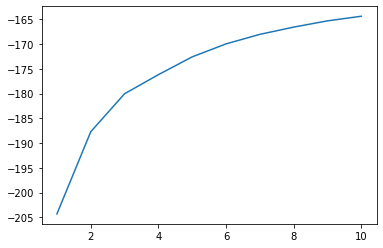

In [19]:
plt.plot(n_range1_2, clf_gs1.cv_results_['mean_test_score'])

In [20]:
# 5.Обучение модели и оценка качества с учетом подобранных гиперпараметров
clf_gs1.best_estimator_.fit(data_train, data_y_train)
target1_0 = clf_gs1.best_estimator_.predict(data_train)
target1_1 = clf_gs1.best_estimator_.predict(data_test)

## Сравнение оценок метрик исходной и оптимальной моделей

In [21]:
# Новое качество модели
r2_score(data_y_train, target1_0), r2_score(data_y_test, target1_1)

(0.9245930167529521, 0.9024037307965285)

In [22]:
# Качество модели до подбора гиперпараметров
r2_score(data_y_train, target0_0), r2_score(data_y_test, target0_1)

(0.9408834310923744, 0.9054334392402374)

In [23]:
# Новое качество модели
mean_squared_error(data_y_train, target1_0, squared=False), mean_squared_error(data_y_test, target1_1, squared=False)

(86.83082113323461, 98.39770517513665)

In [24]:
# Качество модели до подбора гиперпараметров
mean_squared_error(data_y_train, target0_0, squared=False), mean_squared_error(data_y_test, target0_1, squared=False)

(76.88165695362724, 96.85837067132742)

In [25]:
n_range2_2 = np.array(range(1,11,1))
tuned_parameters2_2 = [{'n_neighbors': n_range2_2}]

In [26]:
%%time
clf_gs2 = GridSearchCV(KNeighborsRegressor(), tuned_parameters2_2, cv=ShuffleSplit(), scoring='r2')
clf_gs2.fit(data[['Time(Seconds)', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeSunRise(Seconds)', 'DayLenght(Seconds)', '10', '11', '12', '9']], data['Radiation'])

Wall time: 27.3 s


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=None, test_size=None, train_size=None),
             estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}],
             scoring='r2')

In [27]:
clf_gs2.best_params_

{'n_neighbors': 6}

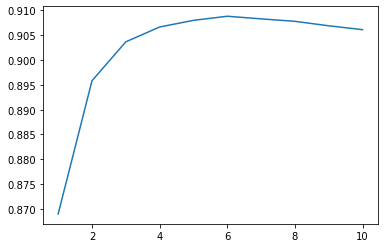

In [28]:
plt.plot(n_range2_2, clf_gs2.cv_results_['mean_test_score'])

In [29]:
# 5.Обучение модели и оценка качества с учетом подобранных гиперпараметров
clf_gs2.best_estimator_.fit(data_train, data_y_train)
target2_0 = clf_gs2.best_estimator_.predict(data_train)
target2_1 = clf_gs2.best_estimator_.predict(data_test)

## Сравнение оценок метрик исходной и оптимальной моделей

In [30]:
# Новое качество модели
r2_score(data_y_train, target2_0), r2_score(data_y_test, target2_1)

(0.9369906171393381, 0.9068410332125085)

In [31]:
# Качество модели до подбора гиперпараметров
r2_score(data_y_train, target0_0), r2_score(data_y_test, target0_1)

(0.9408834310923744, 0.9054334392402374)

## Построение кривых обучения и валидации

In [32]:
from sklearn.model_selection import learning_curve, validation_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.3,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel(str(scoring))
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.4,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'D:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

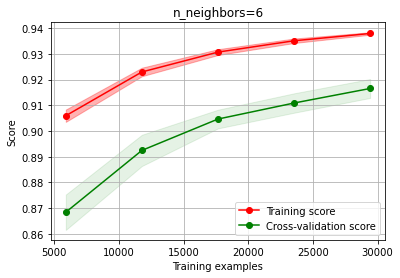

In [33]:
# 6.Построение кривых обучения и валидации
plot_learning_curve(clf_gs2.best_estimator_, 'n_neighbors=6', 
                    data[['Time(Seconds)', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeSunRise(Seconds)', 'DayLenght(Seconds)', '10', '11', '12', '9']], data['Radiation'], cv=ShuffleSplit(), train_sizes=np.linspace(.2, 1.0, 5))

<module 'matplotlib.pyplot' from 'D:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

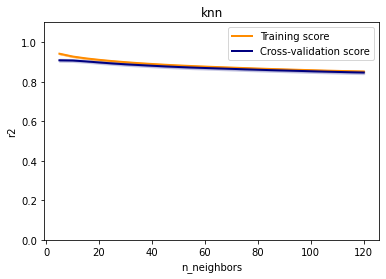

In [34]:
n_range2 = np.array(range(5,125,5))
plot_validation_curve(clf_gs2.best_estimator_, 'knn', 
                      data[['Time(Seconds)', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeSunRise(Seconds)', 'DayLenght(Seconds)', '10', '11', '12', '9']], data['Radiation'], 
                      param_name='n_neighbors', param_range=n_range2, 
                      cv=ShuffleSplit(), scoring="r2")